## Connection to the DB

In [ ]:
%pip install pymysql


import matplotlib.pyplot as plt
import os
import pymysql
import pandas as pd
import numpy as np


succeess = False

while not succeess:
  try:
    conn = pymysql.connect(
        host='db-aff.cpapv35x7rsh.us-east-2.rds.amazonaws.com',
        port=int(3306),
        user="admin",
        passwd="olist2021",
        db='olist',
        charset='utf8mb4')
    db = conn.cursor()
    succeess = True
  except:
    print("Wrong Password")

print("Connection Made")


def add_quotes(s):
  return '"'+str(s)+'",'

def add_quotes_nocomma(s):
  return '"'+str(s)+'"'

     |████████████████████████████████| 43 kB 1.1 MB/s 
Connection Made


## Querying the DB

In [ ]:
df = pd.read_sql_query("""Select  
                          c.customer_unique_id
                          ,DATEDIFF(now(),max(order_purchase_timestamp)) as 'days_since_last_order'
                          ,count(distinct o.order_id) as 'order_count'
                          ,count(distinct od.product_id) as 'distinct_product_count'
                          ,sum(od.qty * od.price) as 'order_sales'
                          ,SUM(case when order_estimated_delivery_date < order_delivered_customer_date then 1 else 0 end) as 'late_order_count'
                          ,SUM(case when order_estimated_delivery_date > order_delivered_customer_date then 1 else 0 end) as 'early_order_count'
                          ,AVG(p.payment_installments) as 'avg_installments'
                          ,count(distinct review_id) as 'review_count'
                          ,avg(r.score) as 'avg_review_score'

                          from customers c 
                          left join orders o on c.customer_id = o.customer_id 
                          left join payments p on o.order_id = p.order_id
                          left join order_details od on o.order_id = od.order_id 
                          left join reviews r on o.order_id = r.order_id
                          group by c.customer_unique_id;
                        """
                        , conn)

# Data Visualizaiton and Cleaning

## Feature Correlation Matrix

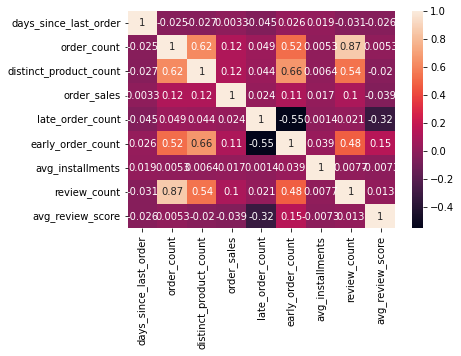

In [ ]:
import seaborn as sn

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

## Feature Value Distributions

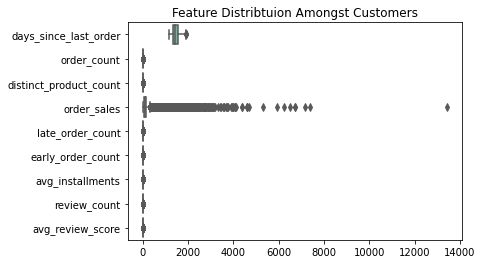

In [ ]:
import seaborn as sns

features = list(df.columns)[1:]

ax = sns.boxplot(data=df, orient="h", palette="Set2").set(title='Feature Distribtuion Amongst Customers')

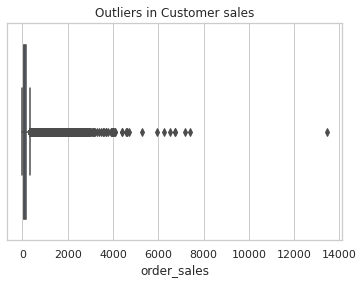

In [ ]:
import seaborn as sns

features = list(df.columns)[1:]

sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=df["order_sales"]).set(title='Outliers in Customer sales')

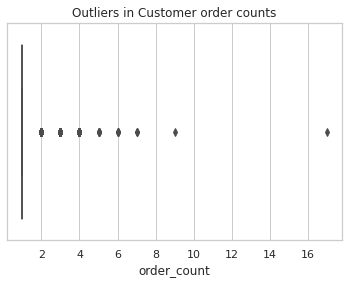

In [ ]:
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=df["order_count"]).set(title='Outliers in Customer order counts')

## Removing Outliers

In [ ]:
df_filtered = df[
              (df.order_sales <=2000 ) &
              (df.order_count <=3)
              ]

df_filtered.shape

(95204, 10)

# Modeling

## Feature Standard Scaling

In [ ]:
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer
from scipy import stats
from sklearn.manifold import TSNE


df_data = df_filtered.iloc[:,1:]
df_data_filtered = df_data.dropna().values
df_data_scaled = StandardScaler().fit_transform(df_data_filtered)

## Selecting the number of clusters using WCSS

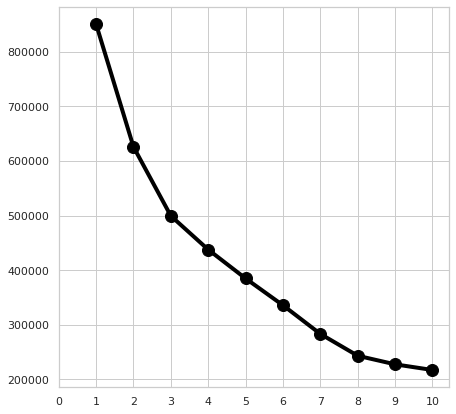

In [ ]:
# Referenced the following for graphing the WCSS by cluster amount
# https://analyticsindiamag.com/beginners-guide-to-k-means-clustering/

from sklearn.cluster import KMeans

WCSS = []
for i in range(1,11):
    model = KMeans(n_clusters = i,init = 'k-means++')
    model.fit(df_data_scaled)
    WCSS.append(model.inertia_)
fig = plt.figure(figsize = (7,7))
plt.plot(range(1,11),WCSS, linewidth=4, markersize=12,marker='o',color = 'black')
plt.xticks(np.arange(11))
plt.show()

## K Means and Birch with t-SNE

### Running t-SNE

In [ ]:
tsnePrincipalComponents = TSNE(n_components=2, learning_rate='auto', init='pca', n_iter=250).fit_transform(df_data_scaled)
tsnePrincipalDf = pd.DataFrame(data = tsnePrincipalComponents)
tsneFeatures = tsnePrincipalDf.to_numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


### KMeans Clustering using t-SNE


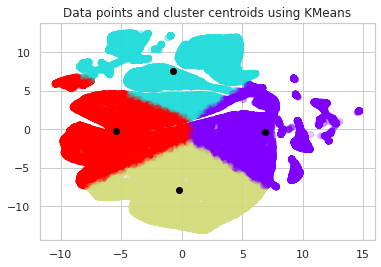

In [ ]:
# KMEANS CLUSTERING
kmeans = KMeans(n_clusters=4, random_state=0).fit(tsneFeatures)

# Plotting the cluster centers and the data points on a 2D plane
plt.scatter(tsneFeatures[:,0], tsneFeatures[:,1], c=kmeans.labels_, cmap='rainbow', alpha=0.2)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], color='black')
plt.xlabel = "PC1"
plt.ylabel = "PC2"
plt.title('Data points and cluster centroids using KMeans')
plt.show()

### Birch Clustering using t-SNE

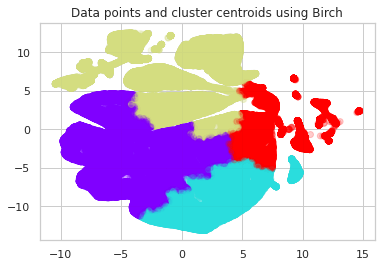

In [ ]:
from sklearn.cluster import Birch

brc = Birch(n_clusters=4)

brc.fit(tsneFeatures)
brc.predict(tsneFeatures)

# Plotting the cluster centers and the data points on a 2D plane
plt.scatter(tsneFeatures[:,0], tsneFeatures[:,1], c=brc.labels_, cmap='rainbow', alpha=0.2)
plt.title('Data points and cluster centroids using Birch')
plt.show()

## K Means and Birch with PCA

### Running PCA

In [ ]:
pca = PCA(n_components=2)
pcaPrincipalComponents = pca.fit_transform(df_data_scaled)
pcaPrincipalDf = pd.DataFrame(data = pcaPrincipalComponents)
pcaFeatures = pcaPrincipalDf.to_numpy()

### Visualize PCA Loadings and Explained Variance

     |████████████████████████████████| 84 kB 2.3 MB/s 
  Created wheel for bioinfokit: filename=bioinfokit-2.0.8-py3-none-any.whl size=56749 sha256=85db1d607e2e43437739ae0db75ce9f40ca9c39033fa0d07947630344224edf7
  Stored in directory: /root/.cache/pip/wheels/0d/b0/a4/2be59655e33c889f2197d43e99ed077f05a6559e24ce28e21a
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7094 sha256=6ae1fa5283d4dc44a5eba60bc36696690c7e47858a34fc1c0b9af6311fbf541d
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built bioinfokit adjustText


TypeError: ignored

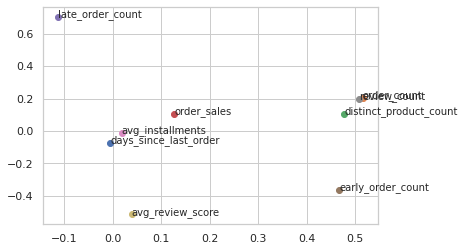

In [ ]:
# Referenced: https://www.reneshbedre.com/blog/principal-component-analysis.html#pca-loadings-plots
%pip install bioinfokit
from bioinfokit.visuz import cluster

loadings = pca.components_


cluster.pcaplot(x=loadings[0], y=loadings[1], labels=df_data.columns.values, 
    var1=round(pca.explained_variance_ratio_[0]*100, 2),
    var2=round(pca.explained_variance_ratio_[1]*100, 2), show=True)

### Kmeans Clustering using PCA

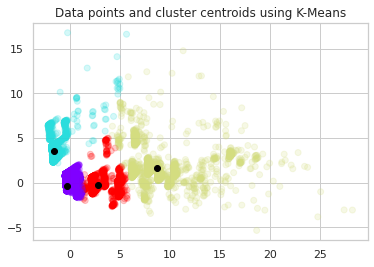

In [ ]:
# KMEANS CLUSTERING
pcaKmeans = KMeans(n_clusters=4, random_state=0).fit(pcaFeatures)

# Plotting the cluster centers and the data points on a 2D plane
plt.scatter(pcaFeatures[:,0], pcaFeatures[:,1], c=pcaKmeans.labels_, cmap='rainbow', alpha=0.2)
plt.scatter(pcaKmeans.cluster_centers_[:,0],pcaKmeans.cluster_centers_[:,1], color='black')
plt.xlabel = "PC1"
plt.ylabel = "PC2"
plt.title('Data points and cluster centroids using K-Means')
plt.show()

### Birch Clustering using PCA

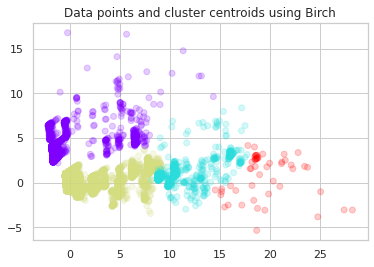

In [ ]:
from sklearn.cluster import Birch

pcaBrc = Birch(n_clusters=4)

pcaBrc.fit(pcaFeatures)
pcaBrc.predict(pcaFeatures)

# Plotting the cluster centers and the data points on a 2D plane
plt.scatter(pcaFeatures[:,0], pcaFeatures[:,1], c=pcaBrc.labels_, cmap='rainbow', alpha=0.2)
plt.title('Data points and cluster centroids using Birch')
plt.show()

In [ ]:
# Referenced: https://towardsdatascience.com/understand-your-data-with-principle-component-analysis-pca-and-discover-underlying-patterns-d6cadb020939

n_components = len(pca.explained_variance_ratio_)
explained_variance = pca.explained_variance_ratio_
cum_explained_variance = np.cumsum(explained_variance)
idx = np.arange(n_components)+1
df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx).T
mean_explained_variance = df_explained_variance.iloc[:,0].mean() # calculate mean explained variance
# (iii.) Print explained variance as plain text
print('PCA Overview')
print('='*40)
print("Total: {} components".format(n_components))
print('-'*40)
print('Mean explained variance:', round(mean_explained_variance,3))
print('-'*40)
print(df_explained_variance.head(20))
print('-'*40)


PCA Overview
Total: 2 components
----------------------------------------
Mean explained variance: 0.25
----------------------------------------
   explained variance  cumulative
1            0.324827    0.324827
2            0.174860    0.499687
----------------------------------------


# Results

In [ ]:
labels = pcaBrc.labels_
df_cluster = pd.DataFrame({'cluster': labels})

df_labels = df_filtered.merge(df_cluster, how='left', left_index=True, right_index=True)
df_labels = df_labels.dropna()

df_labels.groupby("cluster").describe()

days_since_last_order                           ... avg_review_score          
                        count         mean         std  ...              50%  75%  max
cluster                                                 ...                           
0.0                    7437.0  1439.100175  153.980666  ...              5.0  5.0  5.0
1.0                     668.0  1428.700599  146.378041  ...              5.0  5.0  5.0
2.0                   84791.0  1440.420858  153.060875  ...              5.0  5.0  5.0
3.0                      53.0  1459.245283  165.992575  ...              5.0  5.0  5.0

[4 rows x 72 columns]

[Text(0, 0.5, 'Total Order Sales'),
 Text(0.5, 0, 'Cluster'),
 Text(0.5, 1.0, 'Clusters 0 and 2 had customers with higher sales ')]

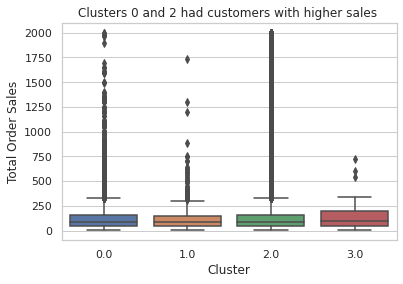

In [ ]:
df_sales = df_labels[["order_sales", "cluster"]]

sns.boxplot(x=df_sales.cluster, y=df_sales.order_sales).set(title='Clusters 0 and 2 had customers with higher sales ', ylabel="Total Order Sales", xlabel="Cluster")

[Text(0, 0.5, 'Total Payment Installments'),
 Text(0.5, 0, 'Cluster'),
 Text(0.5, 1.0, 'Clusters 0 and 2 had customers who used more payment installments ')]

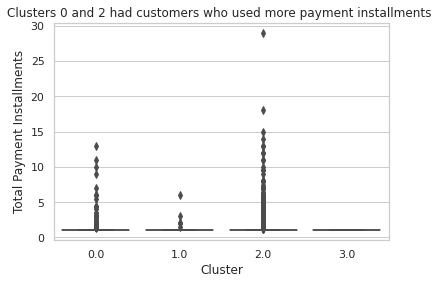

In [ ]:
df_sales = df_labels[["avg_installments", "cluster"]]

sns.boxplot(x=df_sales.cluster, y=df_sales.avg_installments).set(title='Clusters 0 and 2 had customers who used more payment installments '
, ylabel="Total Payment Installments", xlabel="Cluster")

[Text(0, 0.5, 'Customer Avg Review Score'),
 Text(0.5, 0, 'Cluster'),
 Text(0.5, 1.0, 'Cluster 3 with widest interquartile range of review scores')]

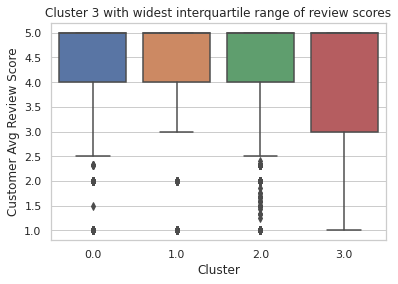

In [ ]:
df_sales = df_labels[["avg_review_score", "cluster"]]

sns.boxplot(x=df_sales.cluster, y=df_sales.avg_review_score).set(title='Cluster 3 with widest interquartile range of review scores'
, ylabel="Customer Avg Review Score", xlabel="Cluster")

[Text(0, 0.5, 'Unique Product Count'),
 Text(0.5, 0, 'Cluster'),
 Text(0.5, 1.0, 'Clusters 0 and 2 bought more unique products')]

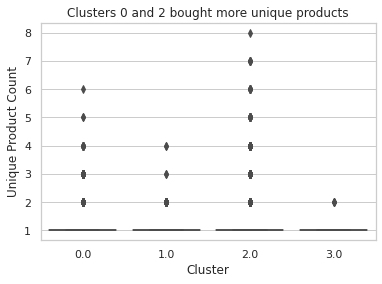

In [ ]:
df_sales = df_labels[["distinct_product_count", "cluster"]]

sns.boxplot(x=df_sales.cluster, y=df_sales.distinct_product_count).set(title='Clusters 0 and 2 bought more unique products', ylabel="Unique Product Count", xlabel="Cluster")
